作为深度学习基础篇章的总结，我们将对本章内容学以致用。下面，让我们动手实战一个Kaggle比赛：房价预测。本节将提供未经调优的数据的预处理、模型的设计和超参数的选择。我们希望读者通过动手操作、仔细观察实验现象、认真分析实验结果并不断调整方法，得到令自己满意的结果

# 3.16.2 获取和读取数据集
比赛数据分为训练数据集和测试数据集。两个数据集都包括每栋房子的特征，如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚至是缺失值“na”。只有训练数据集包括了每栋房子的价格，也就是标签。我们可以访问比赛网页，点击图3.8中的“Data”标签，并下载这些数据集。

我们将通过pandas库读入并处理数据。在导入本节需要的包前请确保已安装pandas库，否则请参考下面的代码注释

In [721]:
# 如果没有安装pandas，则反注释下面一行
# !pip install pandas

%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

2.3.0


假设解压后的数据位于../../data/kaggle_house/目录，它包括两个csv文件。下面使用pandas读取这两个文件（此处复制train.csv和test.csv的绝对路径）

In [722]:
train_data = pd.read_csv(r'C:\Users\Susan_Jay\Desktop\deeplearning\data_housing_price\train.csv')
test_data = pd.read_csv(r'C:\Users\Susan_Jay\Desktop\deeplearning\data_housing_price\test.csv')

训练数据集包括1460个样本、80个特征和1个标签

In [723]:
train_data.shape

(1460, 81)

测试数据集包括1459个样本和80个特征。我们需要将测试数据集中每个样本的标签预测出来

In [724]:
test_data.shape

(1459, 80)

让我们来查看前4个样本的前4个特征、后2个特征和标签（SalePrice）
Pandas中的iloc函数详解：

iloc是Pandas中用于基于整数位置进行数据选择和切片的重要方法，是"integer location"的缩写。它允许你：

通过行号和列号访问数据(从0开始)

使用类似NumPy的整数索引语法

执行精确的位置选择而不考虑标签名称

In [725]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


可以看到第一个特征是Id，它能帮助模型记住每个训练样本，但难以推广到测试样本，所以我们不使用它来训练。我们将所有的训练数据和测试数据的79个特征按样本连结

Pandas 中的 concat 函数详解：

pd.concat 是一个强大的数据合并函数，用于连接多个 DataFrame 或 Series 对象。

concat 函数将多个 Pandas 对象（DataFrame 或 Series）沿着指定的轴连接起来，主要用途包括：

垂直堆叠（行连接）多个数据框

水平组合（列连接）不同的数据框

合并具有相同或不同索引的数据集

In [726]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# 3.16.3 预处理数据
我们对连续数值的特征做标准化（standardization）：设该特征在整个数据集上的均值为μ，标准差为σ。那么，我们可以将该特征的每个值先减去μ再除以σ得到标准化后的每个特征值。对于缺失的特征值，我们将其替换成该特征的均值

标准化的好处：

使不同尺度的特征具有可比性；加快模型训练收敛速度；提高数值稳定性；防止大数值特征支配模型


用均值(0)填充的合理性：

标准化后均值为0，不会引入偏差；简单有效的缺失值处理方法；保持特征分布特性

Lambda函数结构：

lambda: Python中创建匿名函数的关键字

x: 函数的输入参数，此处是Pandas Series对象（一列数据）

表达式: (x - x.mean()) / (x.std())是函数的计算过程和返回值

In [727]:
# all_features.dtypes：获取每一列的数据类型
# all_features.dtypes != 'object'：创建一个布尔掩码，标记非对象(非字符串)类型列
# [...].index：获取符合条件的列名索引
# 目的：识别数据集中的所有数值类型特征（区别于分类特征）
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# .apply()：对每列应用同一函数
# lambda x: (x - x.mean()) / (x.std())：标准化公式，转换每列为均值0、标准差1的分布
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来将离散数值转成指示特征。举个例子，假设特征MSZoning里面有两个不同的离散值RL和RM，那么这一步转换将去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM，其值为0或1。如果一个样本原来在MSZoning里的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0

In [728]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
# 主要作用：将分类特征(文本、枚举类型)转换为数值特征矩阵
# 处理对象：数据框中所有非数值型(object类型)的列
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

可以看到这一步转换将特征数从79增加到了331。

最后，通过values属性得到NumPy格式的数据，并转成Tensor方便后面的训练

In [729]:
# 将所有数据转换为浮点型
all_features = all_features.astype('float32')

n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

# 3.16.4 训练模型
我们使用一个基本的线性回归模型和平方损失函数来训练模型

In [730]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

下面定义比赛用来评价模型的对数均方根误差。给定预测值yˆ1,…,yˆn和对应的真实标签y1,…,yn ，它的定义为

根号(1/n * ∑ (log(yi)−log(yˆi))^2).

对数均方根误差的实现如下

In [731]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 作用: 告诉PyTorch不要计算或存储梯度, 原因: 这是一个评估函数，不需要梯度来更新模型参数
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

# 步骤详解:
# net(features): 使用模型预测房价
# torch.max(..., torch.tensor(1.0)): 将所有预测值截断为不小于1.0
# 为什么要截断: 防止对数函数遇到小于或等于0的值时出现无效值(负无穷)
# 为什么是1.0: 确保对数值非负(log(1)=0)，使结果数值稳定

下面的训练函数跟本章中前几节的不同在于使用了Adam优化算法。相对之前使用的小批量随机梯度下降，它对学习率相对不那么敏感。我们将在之后的“优化算法”一章里详细介绍它

In [732]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# 3.16.5 K折交叉验证
我们在3.11节（模型选择、欠拟合和过拟合）中介绍了K折交叉验证。它将被用来选择模型设计并调节超参数。下面实现了一个函数，它返回第i折交叉验证时所需要的训练和验证数据

In [733]:
# k: 总的折数(例如5折交叉验证中k=5)
# i: 当前选择第i折作为验证集(i从0到k-1)
# X: 特征数据，形状为(样本数, 特征数)的张量
# y: 标签数据，形状为(样本数, 1)的张量
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k     # 计算每折包含的样本数量
    X_train, y_train = None, None   # 初始设置训练集为空，后续会逐步构建
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)   # 使用切片获取第j折的数据范围
        X_part, y_part = X[idx, :], y[idx]   # 提取这部分的特征和标签
        if j == i:
            # 如果j等于i，则这一折用作验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            # 否则，将这一折添加到训练集中，如果是第一次添加，则直接赋值
            X_train, y_train = X_part, y_part
        else:
            # 使用torch.cat在样本维度(dim=0)上拼接张量，构建完整的训练集
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

在K折交叉验证中我们训练K次并返回训练和验证的平均误差

In [734]:
# k: 交叉验证的折数
# X_train: 所有训练特征数据
# y_train: 所有训练标签数据
# num_epochs: 每折训练的轮数
# learning_rate: 学习率
# weight_decay: L2正则化系数
# batch_size: 小批量大小
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0   # 创建变量记录所有折的训练和验证误差总和，用于后续计算平均值
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)   # 将数据分为当前折的训练集和验证集, data包含四个元素
        net = get_net(X_train.shape[1])   # 为每一折创建全新的神经网络
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,   # *data语法将data元组解包为单独的参数传入函数
                                   weight_decay, batch_size)
        
        # 将每折训练完成后的最终误差累加到总和中
        # -1索引获取列表的最后一个元素(最终epoch的误差)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            # 仅为第一折绘制损失随epoch变化的曲线; 使用对数坐标显示，便于观察较小的变化
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    
    # 计算并返回所有k折的平均训练误差和验证误差, 这是评估模型性能的更可靠指标
    return train_l_sum / k, valid_l_sum / k

# 3.16.6 模型选择
我们使用一组未经调优的超参数并计算交叉验证误差。可以改动这些超参数来尽可能减小平均测试误差

fold 0, train rmse 0.132234, valid rmse 0.143960
fold 1, train rmse 0.129391, valid rmse 0.147060
fold 2, train rmse 0.128414, valid rmse 0.142479
fold 3, train rmse 0.133695, valid rmse 0.136761
fold 4, train rmse 0.126063, valid rmse 0.167034
5-fold validation: avg train rmse 0.129959, avg valid rmse 0.147459


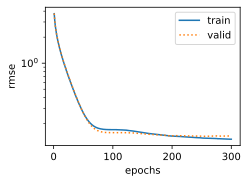

In [735]:
k, num_epochs, lr, weight_decay, batch_size = 5, 300, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

# 3.16.7 预测并在Kaggle提交结果
下面定义预测函数。在预测之前，我们会使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式

In [736]:
# train_features: 训练集特征
# test_features: 测试集特征
# train_labels: 训练集房价标签
# test_data: 原始测试数据框(包含Id列)
# num_epochs: 训练轮数
# lr: 学习率
# weight_decay: L2正则化系数
# batch_size: 小批量大小
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])   # 以特征数量作为输入维度初始化神经网络模型
    train_ls, _ = train(net, train_features, train_labels, None, None,   # None, None表示不使用验证集
                        num_epochs, lr, weight_decay, batch_size)        # 仅保留训练损失记录，忽略验证损失(用_占位)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')   # 以对数坐标显示训练误差随轮数变化
    print('train rmse %f' % train_ls[-1])   # 打印最终训练误差

    # 对测试集进行预测
    # .detach()分离梯度追踪
    # .numpy()转换为NumPy数组便于后续处理
    preds = net(test_features).detach().numpy() 

    # preds.reshape(1, -1) 变换——操作目的: 将数据从"多行一列"转变为"一行多列"
    # [0] 索引操作: 提取转换后数组的第一行(也是唯一的一行)——结果: 得到一维数组，形状为 (n_test,)
    # pd.Series() 转换: 将一维NumPy数组转换为Pandas Series对象
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])   # 将预测值添加到测试数据框的SalePrice列

    # 提取Kaggle要求的两列：样本ID和预测房价
    # axis=1表示在列方向连接
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)   # index=False避免将DataFrame索引写入文件

设计好模型并调好超参数之后，下一步就是对测试数据集上的房屋样本做价格预测。如果我们得到与交叉验证时差不多的训练误差，那么这个结果很可能是理想的，可以在Kaggle上提交结果

train rmse 0.127856


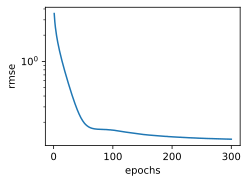

In [737]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

上述代码执行完之后会生成一个submission.csv文件。这个文件是符合Kaggle比赛要求的提交格式的。这时，我们可以在Kaggle上提交我们预测得出的结果，并且查看与测试数据集上真实房价（标签）的误差。具体来说有以下几个步骤：登录Kaggle网站，访问房价预测比赛网页，并点击右侧“Submit Predictions”或“Late Submission”按钮；然后，点击页面下方“Upload Submission File”图标所在的虚线框选择需要提交的预测结果文件；最后，点击页面最下方的“Make Submission”按钮就可以查看结果了

# 小结
通常需要对真实数据做预处理。

可以使用K折交叉验证来选择模型并调节超参数。

最终排名：2275~继续加油!!!!!!